In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_loader.data_loader import PhageLoader
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data import Subset
import seaborn as sns
import math
import json
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

sns.set(rc={'figure.figsize':(15,10)})

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Network class (this might be better off in a separate file)

In [45]:
class GRU(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, output_labels, number_of_layers=1, bidirectional=True, weights_matrix=None):
        super(GRU, self).__init__()
        
        self.bidirectional = bidirectional
        self.hidden_dim_dense = hidden_size
        self.num_layers = number_of_layers 
        if bidirectional:
            self.hidden_dim_dense = hidden_size * 2
        if len(weights_matrix.size())!=0:
            self.emb_layer = self.create_emb_layer(weights_matrix,True)          
        else:
            self.emb_layer = nn.Embedding(vocab_size, embedding_size)
            
        self.gru = nn.GRU(input_size=embedding_size, hidden_size=hidden_size, bidirectional=bidirectional, num_layers=number_of_layers,batch_first=True)
        self.linear = nn.Linear(self.hidden_dim_dense, int(self.hidden_dim_dense/2))
        self.linear2 = nn.Linear(int(self.hidden_dim_dense/2),output_labels)
        
    def forward(self, h_t1, indexes):
        #indexes -> (batch,seq_length)
        embedding = self.emb_layer(indexes)
        #print("EMBEDDING SHAPE: ", embedding.size())
        #embedding -> (batch,seq_length,embedding_size)
        out,h_t = self.gru(embedding, h_t1)
        #print("OUT SHAPE: ", out.size(), self.hidden_dim_dense)
        #out -> ()
        #out = out.view(self.hidden_dim_dense, -1)
        
        out = F.relu(self.linear(out))
        out = self.linear2(out)
        out = F.log_softmax(out,dim=2)
        
        return out,h_t
        
    def initHidden(self, batch_size, hidden_size):      
        if self.bidirectional:
            return torch.randn(self.num_layers*2, batch_size, hidden_size, device=device)
        else:
            return torch.randn(self.num_layers, batch_size, hidden_size, device=device)


    def create_emb_layer(self, weights_matrix, non_trainable=True):
        num_embeddings, embedding_dim = weights_matrix.size()
        emb_layer = nn.Embedding(num_embeddings, embedding_dim)
        emb_layer.load_state_dict({'weight': weights_matrix})
        if non_trainable:
            emb_layer.weight.requires_grad = False
        return emb_layer

## Output file (for computing metrics)

In [46]:
def split_sets(dataset,batch_size,ids=False):
    n = len(dataset)  # how many total elements you have
    test_size = .1
    n_test = int( n * test_size )  # number of test/val elements
    n_train = n - 2 * n_test

    idx = list(range(n))  # indices to all elements
    train_idx = idx[:n_train]
    val_idx = idx[n_train:(n_train + n_test)]
    test_idx = idx[(n_train + n_test):]

    train_dataset = Subset(dataset,train_idx)
    valid_dataset = Subset(dataset,val_idx)
    test_dataset = Subset(dataset,test_idx)
    a = batch_size 

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=a, drop_last=True)
    validation_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=a,drop_last=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=a, drop_last=True)
    if ids:
        return (train_loader,train_idx), (validation_loader,val_idx), (test_loader,test_idx)
    else:
        return train_loader, validation_loader, test_loader

In [58]:
def get_results_formatted(model_name='model5',epoch=100):
    folder = 'models_grid/'
    
    model_selected = model_name+'_'+str(epoch)
    print(model_selected)
    model = torch.load(folder + model_selected,map_location='cpu')
    loader = PhageLoader("data/")
    
    configuration = model_name+'.json'
    f = open(folder + configuration)
    config = json.load(f)
    f.close()

    k_size = config['k_size']
    read_length = config['read_length']
    batch_size = config['batch_size']
    stride = config['stride']
    hidden_size = config['hidden_size']
    batch_size = 1

    dataset = loader.get_data_set(n_files='all',read_length=read_length, batch_size=batch_size, k=k_size, stride=stride, embedding="dict", embed_size=None, drop_last=False)
    list_ids = loader.get_data_set_ids(n_files='all',read_length=read_length, batch_size=batch_size, k=k_size, stride=stride, embedding="dict", embed_size=None, drop_last=False)

    (train_loader,train_idx), (validation_loader,val_idx), (test_loader,test_idx) = split_sets(dataset,batch_size,ids=True)
    indices_validation_set = [list_ids[i] for i in val_idx]
    dataframe_result = predictions_validation(validation_loader, model, indices_validation_set, batch_size,hidden_size,k_size,read_length)
    dataframe_result['gene'] = dataframe_result['id'].str.split('-', n = 1, expand = True)[0]
    dataframe_result['read'] = dataframe_result['id'].str.split('-', n = 1, expand = True)[1]
    return dataframe_result

In [59]:
def predictions_validation(validation_loader,model,indices,batch_size,hidden_size,k_size,read_length):
    output_labels = 2
    df = pd.DataFrame(columns=['id', 'predicted_values', 'true_values'])
    with torch.no_grad(): 
        model.eval()
        hidden = model.initHidden(batch_size,hidden_size)
        id_read = None
        prediction_batch = []
        ytrue_batch = []
        init = True
        for b, (x, y) in enumerate(validation_loader):
            x = x.type(torch.LongTensor)
            y = y.type(torch.LongTensor)
            x, y = x.to(device), y.to(device)
            out,hidden = model(hidden,x)
            
            y = y.view(-1, 1).repeat(1, k_size).view(batch_size,-1)
            y = get_original(y,k_size,1)
            out = out.view(read_length,batch_size,output_labels).exp()
            _, out_index= torch.max(out,dim=-1)
            out_index = out_index.view(-1, 1).repeat(1, k_size).view(batch_size,-1)
            
            out_index = get_original(out_index,k_size,1)
            
            if id_read == indices[b*batch_size: (b+1)*batch_size][0]:
                
                prediction_batch = prediction_batch + out_index
                ytrue_batch = ytrue_batch + y
                
            else:
                if not init:
                    df = df.append({'id' : id_read , 'predicted_values' : prediction_batch,'true_values':ytrue_batch} , ignore_index=True)
                prediction_batch = out_index
                ytrue_batch = y
                init = False
            id_read = indices[b*batch_size: (b+1)*batch_size][0]
        return df

In [60]:
def get_original(predictions,k_size=3,stride=1):
    i=0
    result = []
    while (i+k_size-1) < predictions.size()[1]:
        preds = predictions[0,i*stride:(i+k_size)*(stride)]
        preds = preds.tolist() 
        if i==0:
            result = result + preds
        else:
            result.append(preds[k_size-1])
        i = i + k_size 
    return result

In [61]:
dataframe_result = get_results_formatted()

model5_100


In [27]:
def encode_predictions(read_ids, predicted, save=False):
    
    reading_gene = False
    start = 0
    end = 0
    gene_size = 0
    starts = []
    ends = []
    intervals = []
    sizes = []
    ids = [] 
    
    for i, p in enumerate(predicted):
        if reading_gene:
            if p == 0:
                reading_gene = False
                end = i
                starts.append(start)
                ends.append(end)
                intervals.append('['+str(start)+', '+str(end)+')')
                sizes.append(gene_size)
                ids.append(read_ids[i])
            else:
                gene_size += 1      
        else:
            if p == 1:
                reading_gene = True
                start = i

    if predicted[len(predicted) - 1] == 1:
        end = i + 1
        intervals.append('['+str(start)+', '+str(end)+')')
        starts.append(start)
        ends.append(end)
        sizes.append(gene_size)
        ids.append(read_ids[i])
        
    out = pd.DataFrame({'Read number': ids, \
              'Strand': 1, \
              'Location of the gene in the read': intervals, \
              'Read length': sizes, \
              'Start': starts, \
              'End': ends})
    if save:
        out.to_csv('evaluation_dataframes/' + read_ids[0].split('-')[0] + '.csv')
        
    return out

In [63]:
available_genes = dataframe_result.gene.unique()
total = 0
for gene in available_genes:
    filtered_df = dataframe_result[dataframe_result['gene'] == gene]
    out_frames = []
    for k, r in filtered_df.iterrows():
        predicted = r['predicted_values']
        id_ = r['id']

        temp = encode_predictions([id_ for i in range(len(predicted))], predicted,save=False) 
        total += temp.shape[0]
        out_frames.append(temp)
    out = pd.concat(out_frames)
    out.to_csv('evaluation_dataframes/' + gene + '.csv')
print(total)

6676


In [64]:
dataframe_result

,id,predicted_values,true_values,gene,read
0,NC_029042-88,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NC_029042,88
1,NC_029042-89,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NC_029042,89
2,NC_029042-91,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NC_029042,91
3,NC_029042-93,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NC_029042,93
4,NC_029042-94,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NC_029042,94
5,NC_029042-95,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NC_029042,95
6,NC_029042-96,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NC_029042,96
7,NC_029042-97,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NC_029042,97
8,NC_029042-98,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NC_029042,98
9,NC_029042-99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NC_029042,99


## Configurations dataframe

In [2]:
models = ['model1', 'model2', 'model3', 'model4', 'model5', 'model6']
folders_for_k = ['models_grid/', 'models_k5/']
#folder = 'models_grid/'
configurations = []

for folder in folders_for_k:
    for model in models:
        configuration = model +'.json'
        f = open(folder + configuration)
        config = json.load(f)
        config['folder_to_look'] = folder
        config['loss_train_file_name'] = 'losses_train' + model[len(model)-1]
        config['loss_validation_file_name'] = 'losses_validation' + model[len(model)-1]
        config['base_prediction_name'] = model
        configurations.append(config)
        f.close()

configurations_df = pd.DataFrame(configurations)

In [65]:
configurations_df

,base_prediction_name,batch_size,folder_to_look,hidden_size,k_size,loss_train_file_name,loss_validation_file_name,lr,number_of_layers,optimizer,read_length,stride
0,model1,20,models_grid/,30,3,losses_train1,losses_validation1,0.07,1,SGD,100,1
1,model2,20,models_grid/,30,3,losses_train2,losses_validation2,0.07,1,ADAM,100,1
2,model3,20,models_grid/,30,3,losses_train3,losses_validation3,0.30,1,SGD,100,1
3,model4,20,models_grid/,30,3,losses_train4,losses_validation4,0.30,1,ADAM,100,1
4,model5,20,models_grid/,30,3,losses_train5,losses_validation5,0.07,2,SGD,100,1
5,model6,20,models_grid/,30,3,losses_train6,losses_validation6,0.07,2,ADAM,100,1
6,model1,20,models_k5/,30,5,losses_train1,losses_validation1,0.07,1,SGD,100,1
7,model2,20,models_k5/,30,5,losses_train2,losses_validation2,0.07,1,ADAM,100,1
8,model3,20,models_k5/,30,5,losses_train3,losses_validation3,0.30,1,SGD,100,1
9,model4,20,models_k5/,30,5,losses_train4,losses_validation4,0.30,1,ADAM,100,1


## Charts for losses

In [4]:
import itertools
selected_hypers = ['optimizer', 'lr']
hyper_condigurations = list(itertools.product(*[list(configurations_df[h].unique()) for h in selected_hypers]))
values_per_configuration = []
print(hyper_condigurations)

for i, h_values in enumerate(hyper_condigurations):
    
    df_filters = [configurations_df[h] == h_values[j] for j, h in enumerate(selected_hypers)]
    df_filter = np.bitwise_and.reduce(df_filters, 0)

    losses_list = []
    models_to_evaluate = configurations_df[df_filter]
    for k, v in models_to_evaluate.iterrows():  
        folder = v['folder_to_look'] + v['loss_train_file_name'] + '.pkl'
        losses = pickle.load(open(folder, 'rb'))
        losses_list.append(losses)        

    values_per_configuration.append(np.array(losses_list).T)

[('SGD', 0.07), ('SGD', 0.3), ('ADAM', 0.07), ('ADAM', 0.3)]


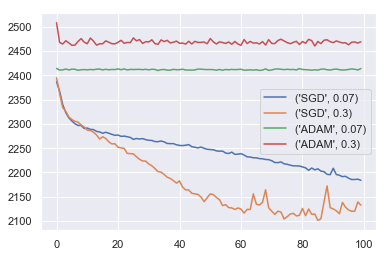

In [5]:
for i, h_value in enumerate(hyper_condigurations):
    chart_data = values_per_configuration[i].mean(axis=1)
    sns.lineplot(x=list(range(100)), y=chart_data, label=h_value)

## Charts for other metrics 

In [ ]:
epochs_values = [20, 40, 60, 80, 100]
selected_hypers = ['optimizer', 'lr']
hyper_condigurations = list(itertools.product(*[list(configurations_df[h].unique()) for h in selected_hypers]))
values_per_configuration = []
print(hyper_condigurations)

for i, h_values in enumerate(hyper_condigurations):
    
    df_filters = [configurations_df[h] == h_values[j] for j, h in enumerate(selected_hypers)]
    df_filter = np.bitwise_and.reduce(df_filters, 0)

    metric_list = []
    models_to_evaluate = configurations_df[df_filter]
    for k, v in models_to_evaluate.iterrows(): 
        across_epochs_metrics = []
        for e in epochs_values:
            
            # load model

            # get predictions with model 

            # get metrics per model per epoch
        
        metric_list.append(across_epochs_metrics)
            

    values_per_configuration.append(np.array(metric_list).T)